In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)
print('done')

done
CPU times: user 15.3 s, sys: 2.88 s, total: 18.2 s
Wall time: 18.3 s


<string>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pac

# Config

In [7]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='PU' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [8]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on hgcal eta acceptance
sel=((np.abs(df_cut['genpart_exeta'])>etamin) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
sel=((np.abs(df_cut['genpart_exeta'])<etamax) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



319230
elec and pions pt cut : 314710 275772
PU:  29757
PU pt cut : 314710 275772
PU:  29757
min eta cut : 294435 256235


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


PU:  29757
max eta cut :  262072 225066


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


PU:  29757
drpna :  262072
PU:  29757
cl3d eta cut: 261150 224441
PU:  29489
done
done layering36
CPU times: user 3min 25s, sys: 11 s, total: 3min 36s
Wall time: 3min 36s


In [10]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df_cut[df_cut['sample']==samp]))

elec 224441
pion 7220
PU 29489


In [12]:
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 6
maxlast=10

for n in range(1,maxfirst):
    Sum=0
    for i in range(n):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5
for n in [1,2,3]:
    Sum = 0
    for i in range(maxpos-(n-1), maxpos+(n-1)+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_{}'.format(n)]=Sum/sumT
        
    
    
    
    

In [13]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 3min 18s, sys: 6.31 s, total: 3min 24s
Wall time: 3min 19s


In [14]:
# try in last lay -> first

In [15]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 3min 18s, sys: 6.07 s, total: 3min 24s
Wall time: 3min 19s


In [19]:
feature_set=2

In [20]:
if feature_set == 1:
    name = 'minimal w/ var'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                'cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer
if feature_set == 2:
    name = 'baseline w/ var'
    features =  ['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']

if feature_set == 3:
    name = 'minimal w/ var & EoT'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer

if feature_set == 4:
    name = 'minimal w/ var & EoT & layervar & bitmap '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1',
       'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_7', 'last_8',
       'last_9', 'firstHcal_1', 'firstHcal_2', 'firstHcal_3', 'firstHcal_4',
       'firstHcal_5', 'firstHcal_6', 'Emax_1', 'Emax_2','Emax_3', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']


if feature_set == 5:
    name = 'minimal w/ var & best pions '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_3', 'ebm1', 'first_4', 'first_5', 'first_3', 'Emax_2']
    
        
if feature_set == 6:
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_6', 'Emax_3', 'ebm1', 'Emax_1', 'first_5', 'Emax_2']

In [21]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


PU


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


signal weight = 1.131388650023837, bkg weight =8.611007494319916


In [29]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [30]:
#normalize features
from sklearn import preprocessing
import pickle
scaler = preprocessing.StandardScaler()
x=data[features]

for key in features:
        print(key, x[key].mean(), x[key].std())
if standardize==  "_Standardized":
    X=scaler.fit_transform(x)
else :X = x
pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))

X_train, X_test, y_train, y_test = train_test_split(X, data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)

# implement different balancing
print('initial',Counter(y_train['signal']))
# SMOTE
oversample=imblearn.over_sampling.SMOTE()
X_smote, y_smote=oversample.fit_resample(X=X_train , y=y_train['signal'])
print('smote',Counter(y_smote))
#ADASYN
oversample=imblearn.over_sampling.ADASYN()
X_ada, y_ada=oversample.fit_resample(X=X_train , y=y_train['signal'])
print('ADASYN',Counter(y_ada))
#Under
undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under=undersample.fit_resample(X=X_train, y=y_train['signal'])
print('under',Counter(y_under))
#over+under
over=imblearn.over_sampling.SMOTE(sampling_strategy=0.2)
under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_comb, y_comb=over.fit_resample(X_train,y_train['signal'])
print('combined',Counter(y_comb))
X_comb, y_comb=under.fit_resample(X_comb, y_comb)
print('combined',Counter(y_comb))

cl3d_showerlength 33.313873902256525 6.683555205171237
cl3d_coreshowerlength 13.728803213484031 2.470836584607421
cl3d_firstlayer 1.0488205410940024 0.6169035971136749
cl3d_maxlayer 10.487850982554248 5.912574041433036
varee 0.0005471128310307413 0.0006476773307545302
varzz 147.6746305611869 339.0702580287475
varpp 0.0005703391541781448 0.0005586966869794029
varrr 1.5940684869515656e-05 8.085489394060199e-06
cl3d_emaxe 0.19251842484289766 0.10320319618084686
cl3d_hoe 0.4740448082801687 4.734092794054594
cl3d_meanz 339.244879933013 9.462249312867145
cl3d_layer10 2.848607159165479 1.794553624151346
cl3d_layer50 5.659929433332256 2.663095582223869
cl3d_layer90 9.532506798952863 3.523373213643541
cl3d_ntc67 14.596222901658766 6.486471554044859
cl3d_ntc90 49.62899199269 14.506189344568796
abseta 2.2655275776820387 0.37417914382101286
initial Counter({1: 179563, 0: 23581})
smote Counter({1: 179563, 0: 179563})
ADASYN Counter({0: 181187, 1: 179563})
under Counter({1: 47162, 0: 23581})
combine

In [31]:
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
if balancing == 'SMOTE':
    X_train=X_smote
    y_train=pd.DataFrame(y_smote)
    y_train['weight']=1
    
    
elif balancing == 'ada':
    X_train=X_ada
    y_train=pd.DataFrame(y_ada)
    y_train['weight']=1
    
elif balancing == 'under':
    X_train=X_under
    y_train=pd.DataFrame(y_under)
    y_train['weight']=1
    
elif balancing == 'comb':
    X_train=X_comb
    y_train=pd.DataFrame(y_comb)
    y_train['weight']=1


train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)


In [32]:
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/{}'.format(genptcut, bkg, feature_set, balancing)
os.makedirs(res_dir, exist_ok=True)

In [33]:
%%time
opti=False
if opti ==True:
    param = {
        # Parameters that we are going to tune.
        'nthread':16,
        'max_depth':4,
        'eta':0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
    }


    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        print('gpu available')
        param['tree_method']='gpu_hist'
    else: print('no gpu found')



    num_boost_round=200
    
    #watchlist=
    progress={}

    metrics={'logloss','auc'} #last one used for es




    # grid search:
    gridsearch_params = [
        (max_depth, eta, l1, l2, es_rounds)
        for max_depth in [2,3,4]
        for eta in [0.001,0.005,0.01,0.05,0.1]
        for l1 in [0.01, 0.1,1,10] #alpha, def= 0
        for l2 in [0.01, 0.1,1,10] #lambda, def=1
        for es_rounds in [3,5]
    ]
    
    tot_iter=len(gridsearch_params)
    n_iter=0
    max_score = 0
    best_params = None
    for max_depth, eta, l1, l2,es_rounds in gridsearch_params:
        n_iter+=1
        print("CV {}/{} with max_depth={}, eta={}, l1={}, l2={}, es={}".format(n_iter, tot_iter,
                                 max_depth, eta, l1, l2, es_rounds))
        # Update our parameters
        param['max_depth'] = max_depth
        param['eta'] = eta
        param['alpha']= l1
        param['lambda']=l2
        # Run CV
        cv_results = xgb.cv(
            param,
            train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'auc'},
            early_stopping_rounds=es_rounds
        )
        # Update best MAE
        alpha=10 #heavy empohasis on keeping train/test close
        mean_score = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
        boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
        print("\tScore {} in {} rounds".format(mean_score, boost_rounds))
        if mean_score > max_score:
            max_score = mean_score
            best_params = (max_depth,eta, l1, l2, es_rounds)
    print("Best params: {},  Score: {}".format(best_params, max_score))

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 22.4 µs


minimal best : (2,0.1,0.01,10,3)
full best (2,0.01,10,10,5)

W0630 09:56:52.396175 140527466166080 deprecation.py:323] From <ipython-input-34-072b196206bf>:17: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


best score:0.9958656000000001 reached in 199 rounds


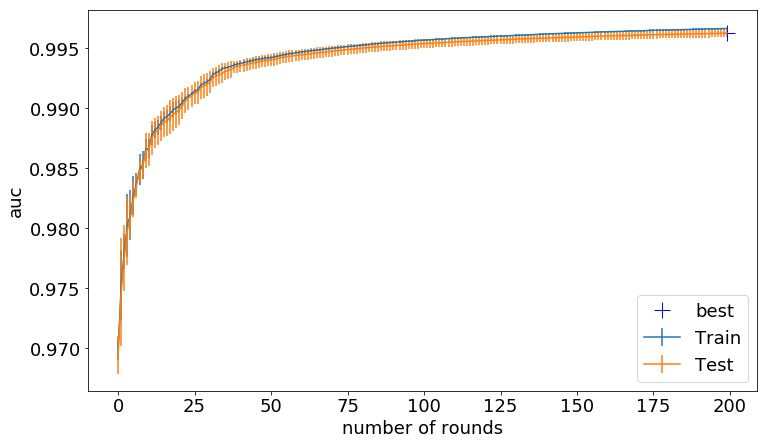

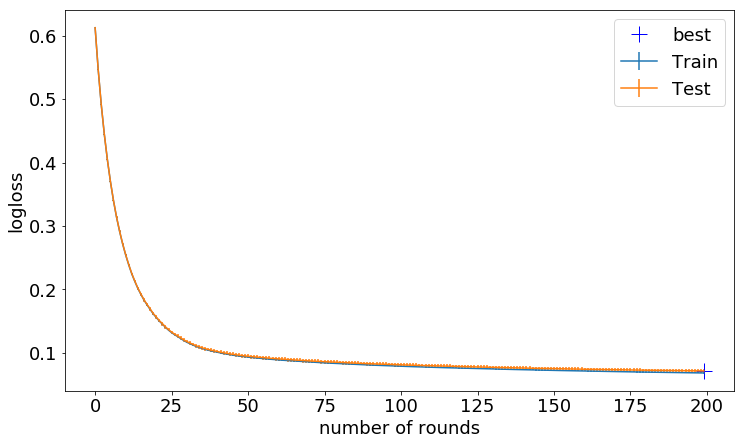

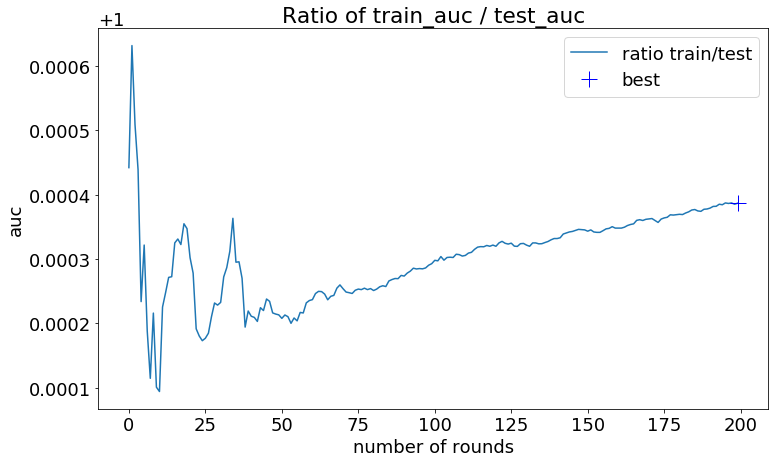

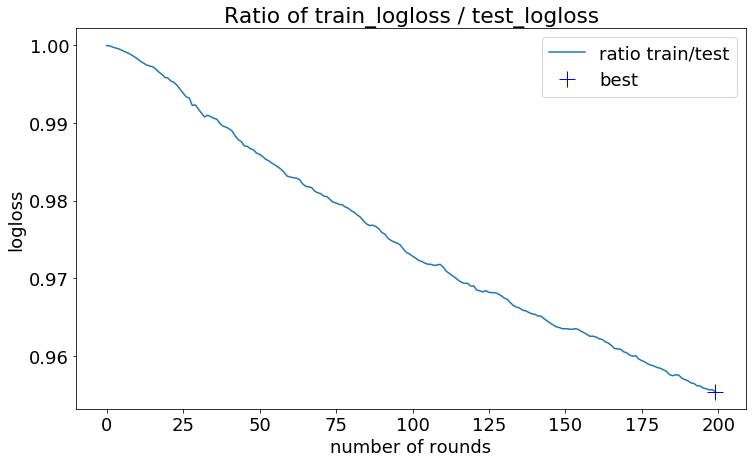

In [34]:
param = {
    'nthread' : 8,
    # Parameters that we are going to tune.
    'max_depth':2,
    'eta':0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': 'auc', 
    'alpha':0.01,
    'lambda':10,
}

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=40,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=2
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))


for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    plt.errorbar(x=x_axis,y=cv_results['train-{}-mean'.format(metric)],xerr=None, yerr=cv_results['train-{}-std'.format(metric)], label='Train')
    plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, cv_results['test-{}-mean'.format(metric)][boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.4,0.9)
    plt.xlabel('number of rounds')
    plt.legend()
    plt.savefig(res_dir+'/{}.png'.format(metric))

#plot ratio train/test
for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    ratio = (cv_results['train-{}-mean'.format(metric)]/cv_results['test-{}-mean'.format(metric)])
    plt.plot(ratio, label='ratio train/test')
    #plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, ratio[boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.8,1.2)
    plt.xlabel('number of rounds')
    plt.title('Ratio of train_{} / test_{}'.format(metric, metric))
    plt.legend()
    plt.savefig(res_dir+'/{}_ratio.png'.format(metric))

Training on 107736 events, signal : 71824, bkg: 35912
Testing on 50786 events, signal : 44878, bkg: 5908
[0]	Train-auc:0.96992	Test-auc:0.96720
[10]	Train-auc:0.98676	Test-auc:0.98574
[20]	Train-auc:0.99011	Test-auc:0.98859
[30]	Train-auc:0.99213	Test-auc:0.99063
[40]	Train-auc:0.99369	Test-auc:0.99284
[50]	Train-auc:0.99419	Test-auc:0.99338
[60]	Train-auc:0.99454	Test-auc:0.99371
[70]	Train-auc:0.99489	Test-auc:0.99400
[80]	Train-auc:0.99523	Test-auc:0.99433
[90]	Train-auc:0.99543	Test-auc:0.99454
[98]	Train-auc:0.99560	Test-auc:0.99469
model saved
KS test passed for sig: cannot distinguish the 2 distributions (pvalue =0.8042312457563264)
KS test passed for bkg: cannot distinguish the 2 distributions (pvalue =0.835430710283906)
AUC Score (Test): 99.469168%
AUC Score (Test): 99.559834%
AUC Score (Test): 99.514865%


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


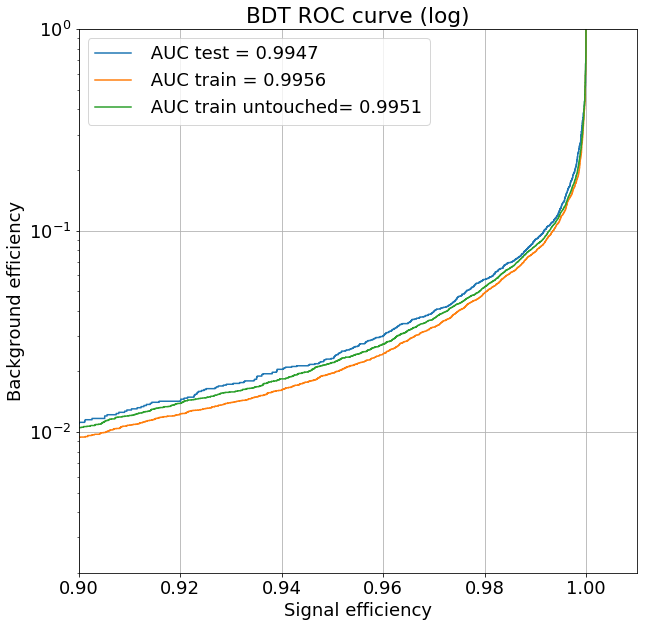

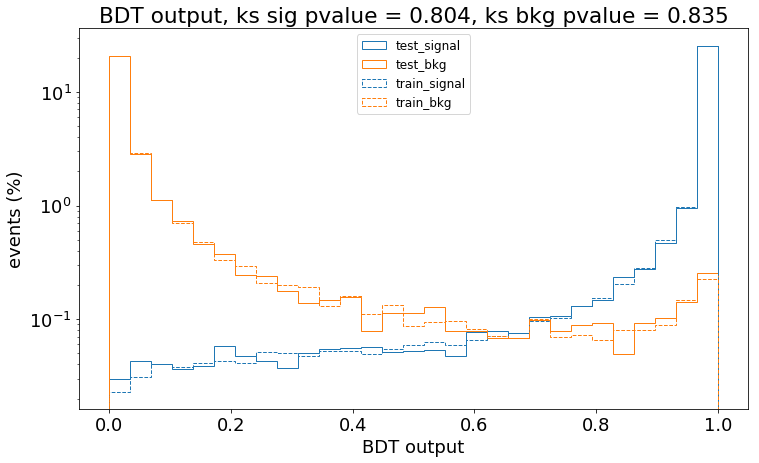

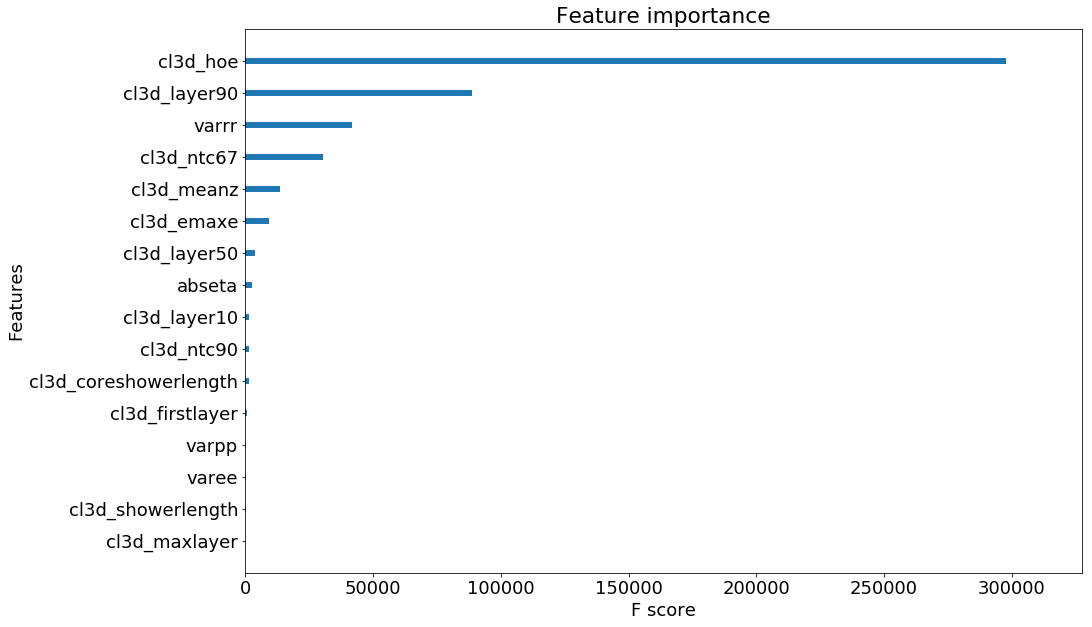

In [35]:
#Now train and fit best parameters BDT



print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds/2),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=10,
)
BDT.save_model(res_dir+'/model.model')
print('model saved')
predictions_BDT_test=BDT.predict(test)
predictions_BDT_train=BDT.predict(train)
predictions_BDT_train_untouched=BDT.predict(train_untouched)
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

#kolmogorov test 
from scipy import stats
ks_test_sig=stats.ks_2samp(predictions_BDT_test[y_test['signal']==1],predictions_BDT_train_untouched[y_train_untouched['signal']==1])
ks_test_bkg=stats.ks_2samp(predictions_BDT_test[y_test['signal']==0],predictions_BDT_train_untouched[y_train_untouched['signal']==0])
if ((ks_test_sig[1]>=0.05) & (ks_test_bkg[1]>=0.05)):  #pass test if pvalue > 5%
    print('KS test passed for sig: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_sig[1]))
    print('KS test passed for bkg: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_bkg[1]))
else: 
    print('KS test failed (pvalue ={}),Sig distributions are too different, check overtraining '.format(ks_test_sig[1]))
    print('KS test failed (pvalue ={}),Bkg distributions are too different, check overtraining '.format(ks_test_bkg[1]))
    

#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC test = %0.4f' %(roc_auc_test))

fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_train))
plt.plot(tpr,fpr, label =' AUC train = %0.4f' %(roc_auc_train))

fpr, tpr, threshold = roc_curve(y_train_untouched['signal'].astype('int32'),predictions_BDT_train_untouched, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_train_untouched = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_train_untouched))
plt.plot(tpr,fpr, label =' AUC train untouched= %0.4f' %(roc_auc_train_untouched))

plt.yscale('log')
plt.xlim(0.9,1.01)
plt.ylim(2e-3,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC.png')
#plot BDT ouput by sample
plt.figure(figsize=(12,7))
x=[]
nbins=30
 
plt.hist(predictions_BDT_test[y_test['signal']==1],bins=np.linspace(0,1,nbins), label='test_signal', density=True, histtype='step', color='C0')
plt.hist(predictions_BDT_test[y_test['signal']==0],bins=np.linspace(0,1,nbins), label='test_bkg', density=True, histtype='step', color='C1')
plt.hist(predictions_BDT_train_untouched[y_train_untouched['signal']==1],bins=np.linspace(0,1,nbins), label='train_signal', density=True, histtype='step', linestyle='dashed', color='C0')
plt.hist(predictions_BDT_train_untouched[y_train_untouched['signal']==0],bins=np.linspace(0,1,nbins), label='train_bkg', density=True, histtype='step', linestyle='dashed', color='C1')
plt.xlabel('BDT output')
plt.ylabel('events (%)')
plt.yscale('log')
plt.title('BDT output, ks sig pvalue = {:.3f}, ks bkg pvalue = {:.3f}'.format(ks_test_sig[1], ks_test_bkg[1]))
plt.legend(fontsize=12, loc = 'upper center')
plt.savefig(res_dir+'/BDToutput_trainvstest.png')

#plot importance
#importance
plt.figure(figsize=(15,10))
ax=plt.subplot(111)
xgb.plot_importance(BDT,ax,grid=False, importance_type='total_gain', show_values=False);
plt.savefig(res_dir+'/importance_totalgain.png')
    

# save config:
file_name=res_dir+'/BDTconfig.txt'
with open(file_name, 'w') as f:
    f.write('BDT config:   \n ')
    f.write('params = {} \n n_rounds= {} \n auc_train ={}\n auc_test={} \n ks_test_sig={} \n ks_test_bkg = {}'.format(param, boost_rounds, roc_auc_train, roc_auc_test, ks_test_sig, ks_test_bkg))
    f.write('input_list: {}\n'.format(features))
    f.write('Training on {} events, signal : {}, bkg: {}\n'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
    f.write('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
    

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


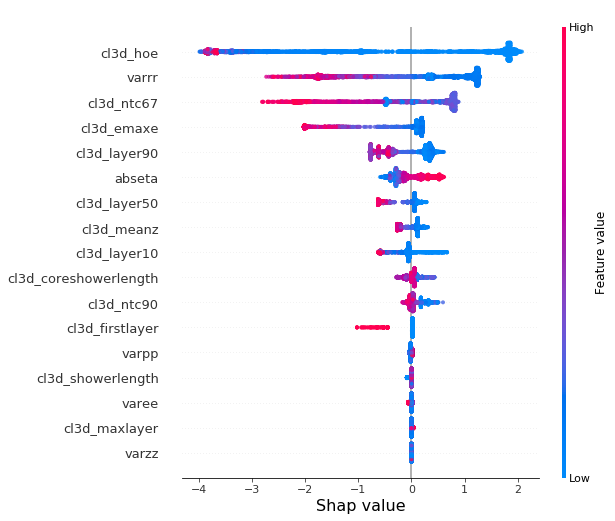

In [39]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= data[features][(data['signal']==1).values].sample(2000)
b = data[features][(data['signal']==0).values].sample(2000)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())
col_names=[val for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')

plt.figure(figsize=(10,5))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() ,shap_df.columns,max_display=99, show=False, alpha = 0.8 )
plt.xlabel('Shap value', fontsize=16)

plt.savefig(res_dir+'/importance_violin.png', bbox_inches='tight')
